# Solving Shidoku using Gröbner bases

The following notebook provides solutions for the sample Shidoku given in Figure 2 (left) in `main.pdf` using the *product-quotient method*, the *roots of unity method*, the *sum-product method*, and the *boolean-variable* method.

In [1]:
from sympy import *
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
puzzle = np.asarray(
    [
        [3,0,0,0],
        [0,2,0,4],
        [0,1,0,0],
        [0,0,4,0]
    ]
)

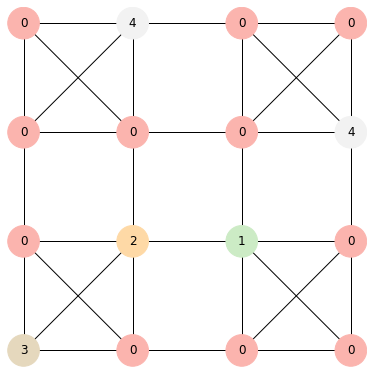

In [3]:
# https://networkx.org/nx-guides/content/generators/sudoku.html

n = 2
G = nx.sudoku_graph(n)
mapping = dict(zip(G.nodes(), puzzle.flatten()))
pos = dict(zip(list(G.nodes()), nx.grid_2d_graph(n * n, n * n)))

# we map the nodes 1-9 to a colormap
low, *_, high = sorted(mapping.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Pastel1)

plt.figure(figsize=(5, 5))
nx.draw(
    G,
    labels=mapping,
    pos=pos,
    with_labels=True,
    node_color=[mapper.to_rgba(i) for i in mapping.values()],
    width=1,
    node_size=1000,
)
plt.show()

In [4]:
# initialises variables to solve for
var('x')
vertices = [Symbol('x' + str(i)) for i in list(G.nodes)]
edges = [(vertices[i], vertices[j]) for i, j in list(G.edges)]

---
---

## Quotient Method

In [5]:
# ideal I_S generated by the product-quotient method 
ideal_s = []

def F_i(x, n):
    prod = 1
    for i in range(1,n+1):
        prod *= (x-i)
    return prod

for x in vertices:
    ideal_s.append(F_i(x,4))
for i,j in edges:
    H_ij,_ = div(F_i(i,4) - F_i(j,4), i-j)
    ideal_s.append(H_ij)

puzzle_clues = [Symbol('x0')-3, Symbol('x5')-2, Symbol('x7')-4, Symbol('x9')-1, Symbol('x14')-4]
ideal_s.extend(puzzle_clues)

g_basis_s = groebner(ideal_s)

# check whether there is a solution, i.e., V(I) != emptyset
g_basis_s != [1]

True

In [6]:
# reduced Groebner basis
g_basis_s

GroebnerBasis([x0 - 3, x1 - 4, x2 - 1, x3 - 2, x4 - 1, x5 - 2, x6 - 3, x7 - 4, x8 - 4, x9 - 1, x10 - 2, x11 - 3, x12 - 2, x13 - 3, x14 - 4, x15 - 1], x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, domain='ZZ', order='lex')

In [7]:
solution_s = solve(g_basis_s, vertices)
solution_s

{x0: 3,
 x1: 4,
 x2: 1,
 x3: 2,
 x4: 1,
 x5: 2,
 x6: 3,
 x7: 4,
 x8: 4,
 x9: 1,
 x10: 2,
 x11: 3,
 x12: 2,
 x13: 3,
 x14: 4,
 x15: 1}

## Roots of Unity Method

In [8]:
# initialise roots of unity 
unityroots = roots(x**4 - 1, multiple=True)

In [9]:
# initialises generators of I_RoI
ideal_roi = []
for x in vertices:
    ideal_roi.append(x**4 - 1)
for x_i, x_j in edges:
    ideal_roi.append((x_i+x_j)*(x_i**2+x_j**2))
    
# add in shidoku puzzle constraints (given cells)
puzzle_clues = [Symbol('x0')+I, Symbol('x5')+1, Symbol('x7')-1, Symbol('x9')-I, Symbol('x14')-1]
ideal_roi.extend(puzzle_clues)

g_basis_roi = groebner(ideal_roi, *vertices)

# check whether there is a solution, i.e., V(I) != emptyset
g_basis_roi != [1]

True

In [10]:
solution_roi = solve(g_basis_roi, vertices)
solution_variables_roi = {}

for item in solution_roi:
    if solution_roi[item] == I:
        solution_variables_roi[item] = 1
    if solution_roi[item] == -1:
        solution_variables_roi[item] = 2
    if solution_roi[item] == -I:
        solution_variables_roi[item] = 3
    if solution_roi[item] == 1:
        solution_variables_roi[item] = 4
solution_variables_roi

{x0: 3,
 x1: 4,
 x2: 1,
 x3: 2,
 x4: 1,
 x5: 2,
 x6: 3,
 x7: 4,
 x8: 4,
 x9: 1,
 x10: 2,
 x11: 3,
 x12: 2,
 x13: 3,
 x14: 4,
 x15: 1}

In [11]:
g_basis_roi

GroebnerBasis([x0 + I, x1 - 1, x2 - I, x3 + 1, x4 - I, x5 + 1, x6 + I, x7 - 1, x8 - 1, x9 - I, x10 + 1, x11 + I, x12 + 1, x13 + I, x14 - 1, x15 - I], x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, domain='ZZ_I', order='lex')

---

---

## Sum-Product Method

In [12]:
# initialises generators of I_SP
ideal_sp = []
for x in vertices:
    ideal_sp.append((x-1)*(x-2)*(x-3)*(x-4))

# add in region constraints
for i in range(len(vertices)//4):
    # rows
    ideal_sp.append(Symbol('x' + str(4*i)) + Symbol('x' + str(4*i+1)) 
                    + Symbol('x' + str(4*i+2)) + Symbol('x' + str(4*i+3)) - 10)
    ideal_sp.append(Symbol('x' + str(4*i)) * Symbol('x' + str(4*i+1))  * 
                   Symbol('x' + str(4*i+2)) * Symbol('x' + str(4*i+3)) -24)
    # columns
    ideal_sp.append(Symbol('x' + str(i)) + Symbol('x' + str(i+4)) 
                    + Symbol('x' + str(i+8)) + Symbol('x' + str(i+12)) - 10)
    ideal_sp.append(Symbol('x' + str(i)) * Symbol('x' + str(i+4))  * 
                   Symbol('x' + str(i+8)) * Symbol('x' + str(i+12)) -24)
    
block_region_constraints_sp = [Symbol('x0') + Symbol('x1') + Symbol('x4') + Symbol('x5') - 10,
                            Symbol('x0') * Symbol('x1') * Symbol('x4') * Symbol('x5') - 24,
                            Symbol('x2') + Symbol('x3') + Symbol('x6') + Symbol('x7') - 10,
                            Symbol('x2') * Symbol('x3') * Symbol('x6') * Symbol('x7') - 24,
                            Symbol('x8') + Symbol('x9') + Symbol('x12') + Symbol('x13') - 10,
                            Symbol('x8') * Symbol('x9') * Symbol('x12') * Symbol('x13') - 24,
                            Symbol('x10') + Symbol('x11') + Symbol('x14') + Symbol('x15') - 10,
                            Symbol('x10') * Symbol('x11') * Symbol('x14') * Symbol('x15') - 24]

ideal_sp.extend(block_region_constraints_sp)
    
# add in shidoku puzzle constraints (given cells)
puzzle_clues = [Symbol('x0')-3, Symbol('x5')-2, Symbol('x7')-4, Symbol('x9')-1, Symbol('x14')-4]
ideal_sp.extend(puzzle_clues)

g_basis_sp = groebner(ideal_sp)

# check whether there is a solution, i.e., V(I) != emptyset
g_basis_sp != [1]

True

In [13]:
solution_sp = solve(g_basis_sp, vertices)
solution_sp

{x0: 3,
 x1: 4,
 x2: 1,
 x3: 2,
 x4: 1,
 x5: 2,
 x6: 3,
 x7: 4,
 x8: 4,
 x9: 1,
 x10: 2,
 x11: 3,
 x12: 2,
 x13: 3,
 x14: 4,
 x15: 1}

In [14]:
g_basis_sp

GroebnerBasis([x0 - 3, x1 - 4, x2 - 1, x3 - 2, x4 - 1, x5 - 2, x6 - 3, x7 - 4, x8 - 4, x9 - 1, x10 - 2, x11 - 3, x12 - 2, x13 - 3, x14 - 4, x15 - 1], x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, domain='ZZ', order='lex')

---
---

## Boolean Variable Method

In [15]:
# initialise boolean variables
boolean_variables = [Symbol('x' + str(i) + ',' + str(j)) for i in list(G.nodes) for j in range(1,5)]

In [16]:
# initialises generators of I_BV
ideal_bv = []
for x in boolean_variables:
    ideal_bv.append(x*(x-1))

# add in region constraints
for i in range(len(vertices)):
    ideal_bv.append(Symbol('x' + str(i) + ',1') + Symbol('x' + str(i) + ',2') +
                    Symbol('x' + str(i) + ',3') + Symbol('x' + str(i) + ',4') - 1)

for u,v in G.edges:
    ideal_bv.append(Symbol('x' + str(u) + ',1') * Symbol('x' + str(v) + ',1') + 
                    Symbol('x' + str(u) + ',2') * Symbol('x' + str(v) + ',2') +
                    Symbol('x' + str(u) + ',3') * Symbol('x' + str(v) + ',3') +
                    Symbol('x' + str(u) + ',4') * Symbol('x' + str(v) + ',4'))

# add in shidoku puzzle constraints (given cells)
puzzle_clues = [Symbol('x0,3')-1, Symbol('x5,2')-1, Symbol('x7,4')-1, Symbol('x9,1')-1, Symbol('x14,4')-1]
ideal_bv.extend(puzzle_clues)

g_basis_bv = groebner(ideal_bv)

# check whether there is a solution, i.e., V(I) != emptyset
g_basis_bv != [1]

True

In [17]:
solution_bv = solve(g_basis_bv, boolean_variables)
solution_bv_reduced = {}
for num in solution_bv:
    if solution_bv[num] != 0:
        solution_bv_reduced[num] = 1
solution_bv_reduced

{x0,3: 1,
 x1,4: 1,
 x10,2: 1,
 x11,3: 1,
 x12,2: 1,
 x13,3: 1,
 x14,4: 1,
 x15,1: 1,
 x2,1: 1,
 x3,2: 1,
 x4,1: 1,
 x5,2: 1,
 x6,3: 1,
 x7,4: 1,
 x8,4: 1,
 x9,1: 1}

In [18]:
g_basis_bv

GroebnerBasis([x0,1, x0,2, x0,3 - 1, x0,4, x1,1, x1,2, x1,3, x1,4 - 1, x10,1, x10,2 - 1, x10,3, x10,4, x11,1, x11,2, x11,3 - 1, x11,4, x12,1, x12,2 - 1, x12,3, x12,4, x13,1, x13,2, x13,3 - 1, x13,4, x14,1, x14,2, x14,3, x14,4 - 1, x15,1 - 1, x15,2, x15,3, x15,4, x2,1 - 1, x2,2, x2,3, x2,4, x3,1, x3,2 - 1, x3,3, x3,4, x4,1 - 1, x4,2, x4,3, x4,4, x5,1, x5,2 - 1, x5,3, x5,4, x6,1, x6,2, x6,3 - 1, x6,4, x7,1, x7,2, x7,3, x7,4 - 1, x8,1, x8,2, x8,3, x8,4 - 1, x9,1 - 1, x9,2, x9,3, x9,4], x0,1, x0,2, x0,3, x0,4, x1,1, x1,2, x1,3, x1,4, x10,1, x10,2, x10,3, x10,4, x11,1, x11,2, x11,3, x11,4, x12,1, x12,2, x12,3, x12,4, x13,1, x13,2, x13,3, x13,4, x14,1, x14,2, x14,3, x14,4, x15,1, x15,2, x15,3, x15,4, x2,1, x2,2, x2,3, x2,4, x3,1, x3,2, x3,3, x3,4, x4,1, x4,2, x4,3, x4,4, x5,1, x5,2, x5,3, x5,4, x6,1, x6,2, x6,3, x6,4, x7,1, x7,2, x7,3, x7,4, x8,1, x8,2, x8,3, x8,4, x9,1, x9,2, x9,3, x9,4, domain='ZZ', order='lex')

---
---